# 목차
1. 분석 방향
2. 데이터 Overview
3. 데이터 전처리

---------------
# 1. 분석 방향


## 제안
1. 가격에 따라 판매에 걸릴 시간에 대한 확률 제공 -- 시간 데이터가 없어서 알기 힘듦
2. 팔고자 하는 제품의 가격을 제안하는 서비스(진품명품 같은?)
3. 현재 트렌드랑의 상관관계?
4. 가격이 포함되어 있으면 rm이라고 나왔다고 하는데, 그러면 가격(rm)이 붙은 이름은 어떤 상관관계를 보일까
5. 부담을 누가하냐? if 판매자 : 가격에 배송비 o / elif 구매자 : 가격에 배송비 x --> 플랫폼 수수료(약 10%)가 있으니, 플랫폼 운영자 입장에서는 판매자가 부담하는 게 더 좋다. --> 판매자 부담하면서, 다양한 배송 옵션을 제공해주면?
6. 적절한 카테고리를 지정해주는게 가격에 영향이 있을까? --> 이름과 카테고리의 공통점이 있다면 더 잘 팔리지 않을까? or 이름에 카테고리에 포함된 게 있으면 자동으로 분류?
7. 카테고리가 세분화될수록 가격이 높아질까?
8. 카테고리, 브랜드, 아이템 설명에 결측치가 있는데, 복원하고 결측 여부에 대한 새로운 컬럼을 만들기
9. 제목에 다양한 정보가 포함되어 있으면 가격을 높게 받을 수 있을까?

## 접근 방향

1. 카테고리, 브랜드의 결측 여부를 표시하는 피쳐를 새롭게 생성한다.
2. train, test 데이터를 활용(같은 이름을 찾아서)하여 결측치를 최대한 입력한다.
3. train, test의 NLP 분류 모델을 사용하여 독립변수(상품명)을 이용하여 종속변수(브랜드)를 학습시키고 결측치를 입력한다.

--------------
# 2. 데이터 Overveiw

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

mercari_df=pd.read_csv('train.tsv',sep='\t')
test_df=pd.read_csv('test_stg2.tsv',sep='\t')

In [2]:
mercari_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [4]:
mercari_df.describe(include='all')

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
count,1.482535e+06,1482535,1.482535e+06,1476208,849853,1.482535e+06,1.482535e+06,1482529
unique,NaN,1225273,NaN,1287,4809,NaN,NaN,1281425
top,NaN,Bundle,NaN,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,NaN,NaN,No description yet
freq,NaN,2232,NaN,60177,54088,NaN,NaN,82489
mean,7.412670e+05,NaN,1.907380e+00,NaN,NaN,2.673752e+01,4.472744e-01,NaN
std,4.279711e+05,NaN,9.031586e-01,NaN,NaN,3.858607e+01,4.972124e-01,NaN
min,0.000000e+00,NaN,1.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,NaN
25%,3.706335e+05,NaN,1.000000e+00,NaN,NaN,1.000000e+01,0.000000e+00,NaN
50%,7.412670e+05,NaN,2.000000e+00,NaN,NaN,1.700000e+01,0.000000e+00,NaN
75%,1.111900e+06,NaN,3.000000e+00,NaN,NaN,2.900000e+01,1.000000e+00,NaN


## 스키마 분석
### 속성
1. train_id : 거래 ID
2. name : 상품 이름
3. item_condition_id : 상품 상태(1 : 최상 ~ 5 : 최하)
    1. New (새 상품)
    2. Like New (거의 새 것)
    3. Good (좋음)
    4. Fair (보통)
    5. Poor (불량 또는 부품용)
5. category_name : 카테고리
6. brand_name : 브랜드
7. price : 판매 가격
8. shipping : 배송 주체
    + 0 : 구매자 부담
    + 1 : 판매자 부담
10. item_description : 제품 설명<br><br>
### 데이터 크기
    1482535 rows × 8 columns

--------
# 3. 데이터 전처리

## 중복 제거

In [5]:
# 중복 확인
print(mercari_df.duplicated().sum())
# 49개의 중복 데이터 발견
# 진짜 우연히 같은 걸까? 과적합 방지 drop?

0


In [6]:
mercari_df=mercari_df.drop_duplicates()

## 결측치 처리 

In [7]:
# 결측치 확인
mercari_df.isna().mean()*100
# 이걸 기입 안 해서 가격이 낮은 걸 수도 있으니, 결측 여부에 대한 새로운 피쳐 생성, 기입 가능한 정보는 기입하여 카테고리에 대한 분석 강화

train_id              0.000000
name                  0.000000
item_condition_id     0.000000
category_name         0.426769
brand_name           42.675687
price                 0.000000
shipping              0.000000
item_description      0.000405
dtype: float64

### category_name, brand_name

In [8]:
# 안된 값은 가격에 그러한 영향이 있을 것이다.
mercari_df['no_cate']=mercari_df['category_name'].isna().astype(int)
mercari_df['no_brand']=mercari_df['brand_name'].isna().astype(int)

#### 같은 이름에서 찾기(train)

In [9]:
# 중복되는 상품 이름 찾기
duplicated_name_train=mercari_df[mercari_df['name'].duplicated()]['name'].unique()

# 중복된 이름이면서 'category_name'이 nan값이 아닌 행들에서, 'name','category_name'만 추출, 하나의 이름만 남겨놓고 중복 제거, 이름을 인덱스로 설정, 'category_name'만 추출해서 Series로 반환
duplicated_category=mercari_df[(mercari_df['name'].isin(duplicated_name_train))&(mercari_df['category_name'].notna())][['name','category_name']].drop_duplicates(subset='name').set_index('name')['category_name']
# 'category_name'에서 결측값이 있는 행을 채운다, 어떤걸로? 반환된 시리즈를 결측치가 있는 mercari_df['name']을 키 값으로 찾아서
mercari_df['category_name']=mercari_df['category_name'].fillna(mercari_df['name'].map(duplicated_category))

# 위와 같은 작업, brand_name
duplicated_brand=mercari_df[(mercari_df['name'].isin(duplicated_name_train))&(mercari_df['brand_name'].notna())][['name','brand_name']].drop_duplicates(subset='name').set_index('name')['brand_name']
mercari_df['brand_name']=mercari_df['brand_name'].fillna(mercari_df['name'].map(duplicated_brand))

mercari_df.isna().sum()
# 브랜드 : 1203개 결측치 제거
# 카테고리 : 63773개 결측치 제거
# 이렇게 해도 안 되는 건 결측치 처리

train_id                  0
name                      0
item_condition_id         0
category_name          5124
brand_name           568909
price                     0
shipping                  0
item_description          6
no_cate                   0
no_brand                  0
dtype: int64

#### 같은 이름에서 찾기(test)

In [10]:
# 겹치는 상품 이름 찾기
duplicated_name_test=test_df['name'].unique()

duplicated_category=test_df[(test_df['name'].isin(duplicated_name_test))&(test_df['category_name'].notna())][['name','category_name']].drop_duplicates(subset='name').set_index('name')['category_name']
mercari_df['category_name']=mercari_df['category_name'].fillna(mercari_df['name'].map(duplicated_category))

# 위와 같은 작업, brand_name
duplicated_brand=test_df[(test_df['name'].isin(duplicated_name_test))&(test_df['brand_name'].notna())][['name','brand_name']].drop_duplicates(subset='name').set_index('name')['brand_name']
mercari_df['brand_name']=mercari_df['brand_name'].fillna(mercari_df['name'].map(duplicated_brand))

mercari_df.isna().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          4718
brand_name           542343
price                     0
shipping                  0
item_description          6
no_cate                   0
no_brand                  0
dtype: int64

In [11]:
mercari_df=mercari_df.dropna(subset='category_name')
# 찾고 나서 없는 것은 제거

#### 이름, 설명에서 추출(보류)

### item_description

In [12]:
mercari_df['item_description']=mercari_df['item_description'].fillna('No description yet')
mercari_df[mercari_df['item_description']=='No description yet']

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,no_cate,no_brand
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,0,1
13,13,Sharpener and eraser,1,Other/Office supplies/School Supplies,Scholastic,4.0,1,No description yet,0,0
31,31,"New Lularoe OS leggings, stars",1,"Women/Athletic Apparel/Pants, Tights, Leggings",NaN,50.0,1,No description yet,0,1
90,90,Jewel holder,2,Home/Storage & Organization/Jewelry Boxes & Or...,Target,7.0,1,No description yet,0,0
117,117,Eyeko liquid eyeliner,1,Beauty/Makeup/Eyes,NaN,5.0,1,No description yet,0,1
...,...,...,...,...,...,...,...,...,...,...
1482430,1482430,Nike Jordan's 5c,3,Kids/Girls 2T-5T/Shoes,Nike,14.0,0,No description yet,0,0
1482447,1482447,Wet n Wild Eyelashes,2,Beauty/Makeup/Eyes,Wet n Wild,3.0,1,No description yet,0,0
1482470,1482470,Adidas ultra boost,2,Men/Shoes/Athletic,Adidas,9.0,0,No description yet,0,0
1482496,1482496,Benefit they're real mascara,1,Beauty/Makeup/Eyes,Benefit,8.0,1,No description yet,0,0


## 데이터 변환
### 형식 변환
#### train_id

In [13]:
mercari_df=mercari_df.set_index('train_id')

#### name, category_name, brand_name, item_description

In [14]:
mercari_df[['name','category_name','brand_name','item_description']] = mercari_df[['name','category_name','brand_name','item_description']].astype('string')
# mercari_df['name'] = mercari_df['name'].str.replace(r'[^0-9a-zA-Z\s]', '', regex=True).str.lower()

### 파생변수

#### name

##### 특수기호 사용여부(영어, 숫자, 공백 이외)

In [15]:
mercari_df['contains_special'] = mercari_df['name'].str.contains(r"[^A-Za-z\s]", regex=True)
special_list=[]
for i in mercari_df['name'].str.findall(r"[^A-Za-z\s\d]"):
    special_list.extend(i)
print(set(special_list))

{'▥', '´', '♨', 'π', '化', '\x96', 'ś', '⏰', '복', '̾', 'の', '᙭', '’', 'Ꮪ', 'ᴏ', '€', '☮', 'Ꭱ', ')', 'ń', '⚽', 'ã', 'ṡ', '＃', 'ʙ', '^', '앵', '，', 'ᑭ', '゜', 'ι', '➕', 'ℓ', '❁', '¥', '⚡', 'ყ', '¤', 'ć', '＋', '!', '⚾', '！', '⚃', '．', 'ᖇ', '⛥', 'ᴋ', 'い', '$', 'α', '美', '%', '새', '❣', 'î', '♛', 'ᘔ', '⚝', 'ʔ', 'н', 'å', '⚀', '¯', 'û', '❗', '➶', '＼', '°', 'â', 'ѕ', 'Ü', 'ғ', 'ᴇ', '\u200b', '\\', '❔', '☁', '간', '◠', 'é', '͡', '∆', '➖', 'ā', '✿', '＄', '✴', 'ą', '➰', 'ッ', '⏳', 'ʕ', '▯', '♠', 'Û', '甚', '➥', '☔', '☠', '★', 'Β', '⏬', 'ウ', 'ᖴ', '·', '⬆', '➪', '기', '?', '〰', '✈', 'ぁ', '《', '⛱', 'Ꮓ', 'Ṭ', 'м', '♻', '¶', 'È', 'ổ', '語', 'ʜ', 'Ꮲ', '√', '£', '白', '⛇', '✬', '☯', '⛔', '♦', '♀', 'ツ', 'Ꭲ', '͜', '*', '♡', '（', '✨', '專', '”', 'Є', '⚫', '❌', '♤', '☑', '⚙', 'ト', 'Ō', 'ì', '–', 'ê', '⭐', '⚛', '⌛', '本', '`', '彡', '❖', '☀', '의', 'ŕ', 'Ꮇ', '\x16', '→', '＊', 'ᗷ', 'ば', 'ź', '⚂', 'ķ', '⚅', 'ᴊ', '♭', '⚬', '\u200e', 'ù', '¦', '✔', '리', 'ü', '들', 'Ó', 'ᗰ', '"', '•', 'Ṃ', '❤', 'Ҡ', '행', 'ミ', '✂', '״', '」', 'Ë

##### 숫자 사용여부

In [16]:
mercari_df['contains_number'] = mercari_df['name'].str.contains(r'/d', regex=True)

##### 가격 표시 여부

In [17]:
mercari_df['rm_number'] = mercari_df['name'].str.contains('[rm]', regex=False)

#### category_name(보류 1개)

##### 카테고리 분리 및 카운트

In [18]:
# 어절로 구분해야할까 글자 수로 구분해야할까?
sep_category=mercari_df['category_name'].str.split('/',expand=True)
sep_category.columns=['cate1','cate2','cate3','cate4','cate5']
sep_category['category_count']=sep_category.count(axis=1)
sep_category.head()

,cate1,cate2,cate3,cate4,cate5,category_count
train_id,,,,,,
0,Men,Tops,T-shirts,<NA>,<NA>,3
1,Electronics,Computers & Tablets,Components & Parts,<NA>,<NA>,3
2,Women,Tops & Blouses,Blouse,<NA>,<NA>,3
3,Home,Home Décor,Home Décor Accents,<NA>,<NA>,3
4,Women,Jewelry,Necklaces,<NA>,<NA>,3


In [19]:
print
print(f'1번 분류 : {sep_category['cate1'].nunique()}')
print(f'2번 분류 : {sep_category['cate2'].nunique()}')
print(f'3번 분류 : {sep_category['cate3'].nunique()}')
print(f'4번 분류 : {sep_category['cate4'].nunique()}')
print(f'5번 분류 : {sep_category['cate5'].nunique()}')

1번 분류 : 10
2번 분류 : 113
3번 분류 : 870
4번 분류 : 6
5번 분류 : 2


In [20]:
sep_category['category_count'].value_counts().sort_index()
# 3번 이후의 값은 의미가 없나? 그래도 정밀한 비교를 위해서 남겨놓기로
# 1: 대분류, 2: 중분류, 3: 소분류

category_count
3    1473427
4       1331
5       3059
Name: count, dtype: int64

##### 이름에서 카테고리 찾기(보류)

In [21]:
# '/'와 '&' 기준으로 분리하고 그 값이 이름에도 포함되어있는지 판단하려고 함.
list_category=[]
for i in mercari_df['category_name'].str.split(r'[/&]', regex=True):
    list_category.extend(i)
sr_category=pd.Series(list_category)

sr_category=sr_category.str.lower().str.strip()

sr_category
# é와 같은 영어가 아닌 값도 포함되어있음

0                          men
1                         tops
2                     t-shirts
3                  electronics
4                    computers
                  ...         
5065344             home décor
5065345     home décor accents
5065346                  women
5065347    women's accessories
5065348                wallets
Length: 5065349, dtype: object

In [22]:
sr_category[sr_category.str.contains(r"[^A-Za-z]", regex=True)]
# é - , ' + () 발견

2                     t-shirts
13                  home décor
14          home décor accents
23                   two-piece
44            above knee, mini
                  ...         
5065337            girls 2t-5t
5065342    fitness accessories
5065344             home décor
5065345     home décor accents
5065347    women's accessories
Length: 1167084, dtype: object

In [23]:
mercari_df=pd.concat([mercari_df,sep_category],axis=1).drop('category_name',axis=1)

#### item_description

##### 설명 없음

In [24]:
mercari_df['no_desc'] = (mercari_df['item_description'] == 'No description yet').astype(int)

##### 설명 글자 수

In [25]:
# 설명의 길이가 가격의 영향
mercari_df['desc_len']=mercari_df['item_description'].str.replace('No description yet','').apply(len)

##### 설명 어절 수

In [26]:
#제목에 카테고리 or 브랜드와 매칭이 되는 정보가 있다?
mercari_df['desc_space']=mercari_df['item_description'].str.replace('No description yet','').str.split(r'\s').apply(len)

##### 가격 표시 여부

In [27]:
mercari_df['desc_rm'] = mercari_df['item_description'].str.contains('[rm]', regex=False)

# 보류

## 여러 번 등장한 name (위에서 사용 중)

In [28]:
# 중복되는 상품 찾기
duplicated_name=mercari_df[mercari_df['name'].duplicated()]['name'].unique()
print(duplicated_name)

<StringArray>
[                              'Bundle',
                                'Boots',
                        'Black booties',
                                'Dress',
                     'Pandora bracelet',
         'Giffin 25 rdta full tank kit',
                       'Tommy Hilfiger',
                      'Lululemon crops',
                    'Kate Spade Wallet',
                          'Urban decay',
 ...
                    'Metal mulisha top',
                           'Waist Belt',
  'Dallas Cowboys sport utility gloves',
           'Mary kay botanical effects',
                 'Ankle boots size 6.5',
                'Mac studio fix powder',
  'Jeffrey Star Velour Liquid Lipstick',
            'Victoria secret black bag',
 'New Bath & Body Works Scented Candle',
   'Tarte Amazonian clay 12 hour blush']
Length: 83245, dtype: string


In [29]:
# 컬럼 길이 넓히기
pd.set_option('display.max_colwidth',200)

In [30]:
mercari_df[mercari_df['name'].isin(duplicated_name)].sort_values('name')[['name','item_description']]
# 이름을 !!특가!! 이런식으로 써놓은 것도 있네

,name,item_description
train_id,,
408319,!!!Jewelry Sale!!! 3 days only! [rm],Retro Crystal Butterfly one Ear Cuff Stud Earring Wrap. NWT ( Gold)
966280,!!!Jewelry Sale!!! 3 days only! [rm],Retro Crystal Butterfly one Ear Cuff Stud Earring Wrap. NWT ( Silver)
1081227,!!!Lingerie Sale!!! 3 Days only! [rm],Sexy Black and Brown Bra & Panties Set Hollow Butterfly Perspective Bra & G-string Underwear . NWT.
871965,!!!Lingerie Sale!!! 3 Days only! [rm],Women Sexy Nightwear Black Strap & Bra Thongs Underwear Suit Sleepwear Lace Vest. Ex Small-size with Adjustable straps. NWT.
1147144,!!SALE!! Faux fur Pom Pom Keychain NWT,"One Week SALE POM POM FIRM!! NO FREE SHIPPING! Dusty Rose Faux FurPom Pom Keychain NEW perfect for your purse, not Michael Kors but pretty on them ☺️"
...,...,...
375271,》XMAS SALE! NEW CLASSY SMART WATCH W/CAM,A1 Functions: Bluetooth: this smart watch can connect Smartphone by using Bluetooth Phonebook: the mobile phone contacts will be displayed in the machine when they connect. Dialer: watch is connec...
789311,》free ship《 Usc tshirt,Usc Carolina gamecocks tshirt
1370477,》free ship《 Usc tshirt,Usc Carolina gamecocks Carolina girl t shirt size small


# 그래프

In [31]:
mercari_df=mercari_df[['price', 'name', 'item_condition_id', 'brand_name', 'shipping','item_description', 'no_cate', 'no_brand', 'contains_special','contains_number', 'desc_rm', 'cate1', 'cate2', 'cate3', 'cate4','cate5', 'category_count', 'no_desc', 'desc_len', 'desc_space']]
mercari_df.columns=['가격','이름','제품 상태','브랜드','배송 판매자 부담','제품 설명','카테고리 결측','브랜드 결측','이름 특수기호','이름 숫자','이름 가격','대분류','중분류','소분류','소소분류','소소소분류','카테고리 수','설명 결측','설명 글자 수','설명 어절 수']

## 대분류 카테고리별

대분류
Women                     45.01
Beauty                    14.07
Kids                      11.63
Electronics                8.31
Men                        6.35
Home                        4.6
Vintage & Collectibles     3.15
Other                      3.08
Handmade                   2.09
Sports & Outdoors          1.72
Name: proportion, dtype: Float64


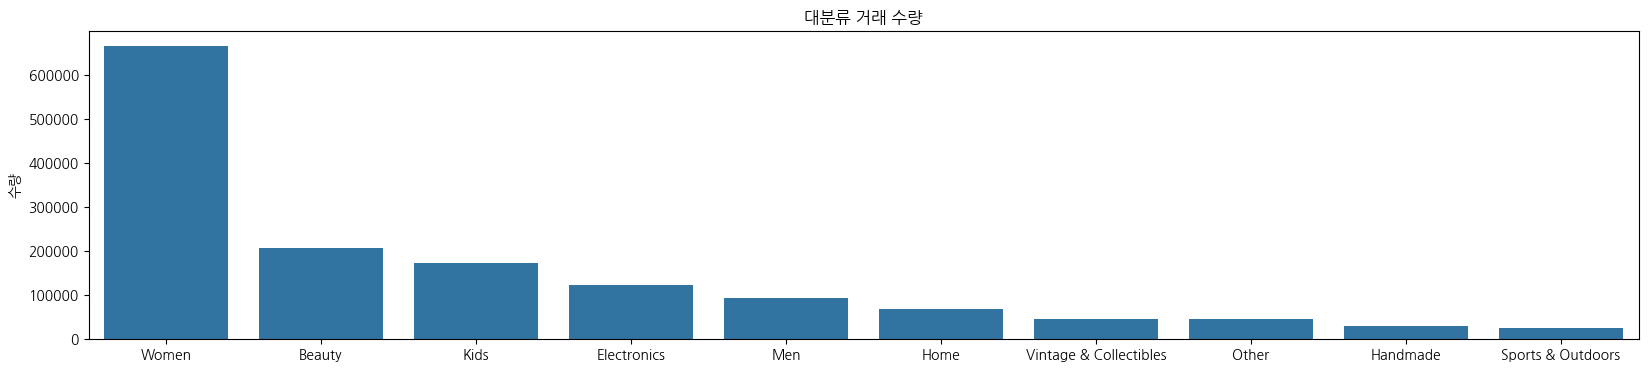

In [32]:
print(round(mercari_df['대분류'].value_counts(normalize=True)*100,2).sort_values(ascending=False))
plt.figure(figsize=(20,4))
sns.countplot(data=mercari_df, x='대분류',order=mercari_df['대분류'].value_counts().index)
plt.title('대분류 카테고리')
plt.xlabel('')
plt.ylabel('수량')
plt.title('대분류 거래 수량')
plt.show()

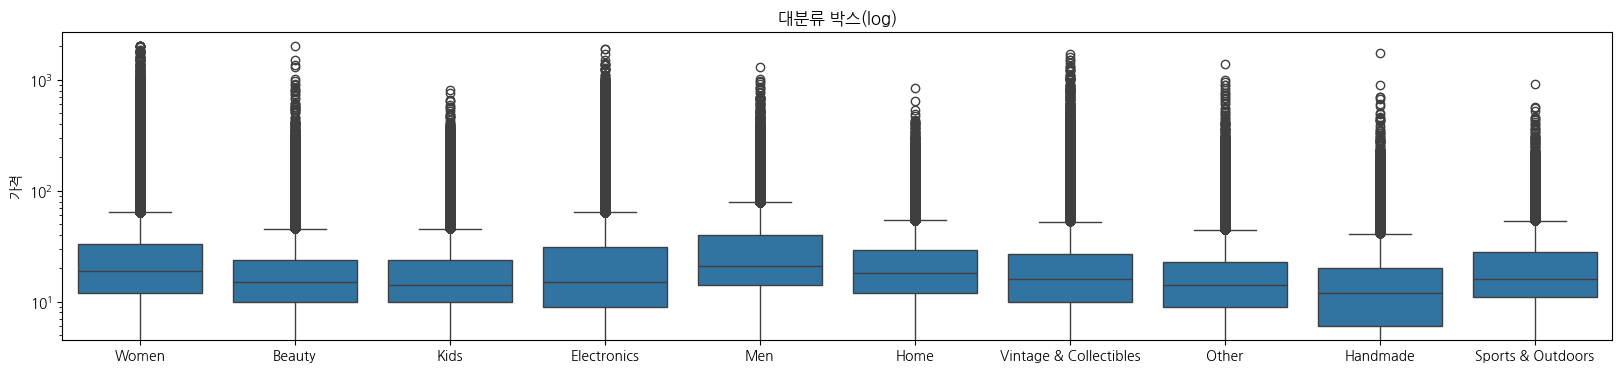

In [33]:
plt.figure(figsize=(20,4))
sns.boxplot(mercari_df, x='대분류', y='가격',order=mercari_df['대분류'].value_counts().index)
plt.yscale('log')
plt.xlabel('')
plt.title('대분류 박스(log)')
plt.show()

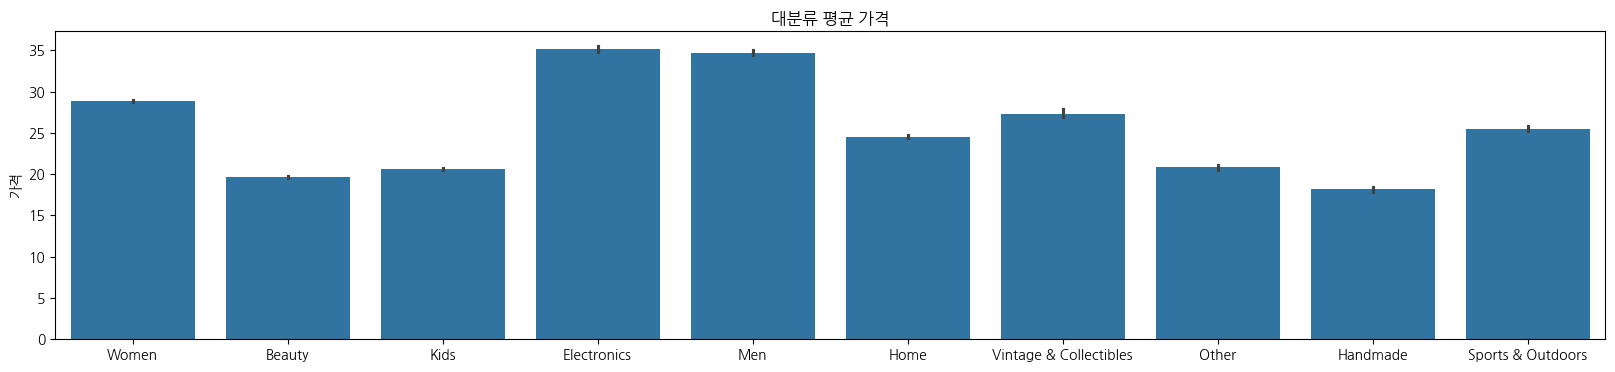

In [34]:
plt.figure(figsize=(20,4))
sns.barplot(mercari_df, x='대분류', y='가격',order=mercari_df['대분류'].value_counts().index)
plt.title('대분류 평균 가격')
plt.xlabel('')
plt.show()

In [35]:
corr_df = mercari_df.groupby('대분류').corr(numeric_only=True).unstack().reindex(['Women', 'Beauty', 'Kids', 'Electronics', 'Men', 'Home','Vintage & Collectibles', 'Other', 'Handmade', 'Sports & Outdoors'])
corr_df.iloc[:,0:12]

가격                                                    \
                         가격     제품 상태 배송 판매자 부담   카테고리 결측    브랜드 결측   이름 특수기호   
대분류                                                                             
Women                   1.0 -0.069640 -0.055055 -0.003079 -0.090070  0.014593   
Beauty                  1.0 -0.014342 -0.151782  0.003589 -0.033463  0.021901   
Kids                    1.0 -0.048364 -0.134077  0.005234 -0.077771  0.013204   
Electronics             1.0  0.120558 -0.162688  0.002582 -0.253173  0.077397   
Men                     1.0 -0.114981 -0.047646  0.003625 -0.131262  0.107651   
Home                    1.0 -0.101504 -0.173518 -0.000901 -0.179514  0.040688   
Vintage & Collectibles  1.0  0.043267 -0.102783 -0.001738 -0.087350 -0.000457   
Other                   1.0  0.021160 -0.140131  0.012403 -0.052519  0.004795   
Handmade                1.0  0.126632 -0.213338 -0.006927  0.000783 -0.002306   
Sports & Outdoors       1.0  0.040160 -0.109164 -0.008933 -0.224197  0.080685   

                                                                          \
                           이름 숫자     이름 가격    카테고리 수     설명 결측   설명 글자 수   
대분류                                                                        
Women                   0.001806  0.079482       NaN -0.033930  0.093210   
Beauty                 -0.001226  0.039272       NaN -0.008940  0.016283   
Kids                   -0.000920  0.049096       NaN -0.029551  0.073802   
Electronics            -0.003068  0.023167  0.093861 -0.058974  0.046233   
Men                    -0.003686  0.040314  0.006341 -0.035567  0.058537   
Home                    0.005027  0.046235       NaN -0.015816  0.065564   
Vintage & Collectibles -0.002827  0.031976       NaN -0.032142  0.072588   
Other                  -0.003495  0.011549       NaN -0.024389 -0.033138   
Handmade               -0.005481 -0.019290  0.009674 -0.023414 -0.001547   
Sports & Outdoors       0.000145  0.075771 -0.000296 -0.028112  0.022160   

                                  
                         설명 어절 수  
대분류                               
Women                   0.089014  
Beauty                  0.015009  
Kids                    0.074302  
Electronics             0.048623  
Men                     0.062385  
Home                    0.064726  
Vintage & Collectibles  0.073307  
Other                  -0.035104  
Handmade               -0.003968  
Sports & Outdoors       0.024838

### 상관관계 가이드라인
 + |r| < 0.1
상관 없음(Negligible)
 + 0.1 ≤ |r| < 0.3
매우 약한 상관(Very Weak)
 + 0.3 ≤ |r| < 0.5
약한 상관(Weak)
 + 0.5 ≤ |r| < 0.7
중간 정도의 상관(Moderate)
 + 0.7 ≤ |r| < 0.9
강한 상관(Strong)
 + |r| ≥ 0.9
매우 강한 상관(Very Strong)
### 기본 발견
1. 카테고리는 기본적으로 3가지를 입력하게 되어있다. (최소 3, 제품에 따라 최대 5) 따라서, 3가지를 각각 대분류, 중분류, 소분류로 사용 가능하다.
2. 카테고리에 따라 기본적인(평균) 가격대를 예상할 수 있다. -> 입력한 카테고리를 바탕으로 가격을 예측해주는 요소로 활용 가능

### 속성 발견
1. 제품 상태
   + [Electronics, Vintage & Collectibles, Other, Handmade, Sports & Outdoors]에서는 상품의 상태와 가격이 비례하지 않는다.
2. 배송 부담 주체
   + 모든 대분류에서 판매자가 부담을 했을 시, 가격이 감소됨을 확인할 수 있다.
4. 결측 여부
   + 카테고리에 대한 결측 여부는 대조할만한 값이 충분하지 않기 때문(1609개의 데이터밖에 존재하지 않음)에 상관관계를 입증하기 어렵다.
   + Handmade를 제외하고는 브랜드가 없을 시 가격이 하락한다. / Handmade는 브랜드가 없기 때문에 가격과 상관관계가 없다.
6. 이름에 포함된 요소
   + 특수기호, 숫자, 가격이 포함되었다고 하여 상관관계가 있다고 볼 수 없다.
8. 카테고리 수
   + 관계 없음
10. 제품 설명
    + 관계 없음

## 중분류 카테고리별

In [36]:
pd.set_option('display.max_rows',138)
mercari_df.groupby(['대분류','중분류'])['가격'].count().reset_index()

,대분류,중분류,가격
0,Beauty,Bath & Body,7763
1,Beauty,Fragrance,24331
2,Beauty,Hair Care,7775
3,Beauty,Makeup,124715
4,Beauty,Other,490
5,Beauty,Skin Care,29858
6,Beauty,Tools & Accessories,13059
7,Electronics,Cameras & Photography,3981
8,Electronics,"Car Audio, Video & GPS",516
9,Electronics,Cell Phones & Accessories,53307


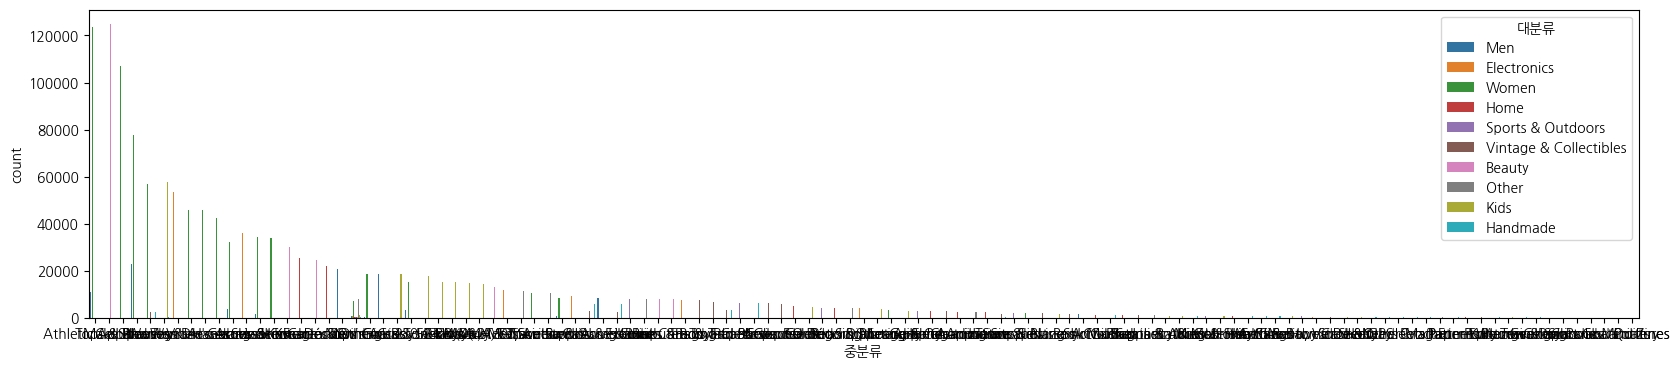

In [37]:
plt.figure(figsize=(20,4))
sns.countplot(mercari_df, x='중분류', hue='대분류',order=mercari_df['중분류'].value_counts().index)
plt.show()

In [38]:
corr_dict = {}

# 대분류 순서를 유지한 채로 생성
cate2_list = mercari_df[['대분류','중분류']].sort_values('대분류')['중분류'].drop_duplicates()
for i in cate2_list:
    subset = mercari_df[mercari_df['중분류'] == i]
    corr = subset.corr(numeric_only=True)['가격']   # 가격과의 상관만 추출
    corr_dict[i] = corr


corr_df = pd.DataFrame(corr_dict).T

In [39]:
corr_df.head()

,가격,제품 상태,배송 판매자 부담,카테고리 결측,브랜드 결측,이름 특수기호,이름 숫자,이름 가격,카테고리 수,설명 결측,설명 글자 수,설명 어절 수
Fragrance,1.0,-0.025468,-0.119987,-0.004453,-0.006696,0.081100,NaN,0.086997,NaN,-0.016990,0.071232,0.072650
Hair Care,1.0,-0.077020,-0.162090,0.033131,0.066351,0.044451,0.009493,0.083221,NaN,-0.008733,0.067516,0.067929
Skin Care,1.0,-0.022032,-0.137304,0.000852,0.060552,0.035399,0.005982,0.085660,NaN,-0.023219,-0.004306,-0.005969
Makeup,1.0,-0.019543,-0.138376,0.004817,-0.081349,0.001364,-0.003318,0.014590,NaN,0.000178,0.016686,0.013684
Tools & Accessories,1.0,0.058004,-0.212908,-0.006088,-0.007055,-0.017621,-0.004299,0.108072,NaN,-0.045219,0.039875,0.040509


In [59]:
corr_df.columns

Index(['가격', '제품 상태', '배송 판매자 부담', '카테고리 결측', '브랜드 결측', '이름 특수기호', '이름 숫자',
       '이름 가격', '카테고리 수', '설명 결측', '설명 글자 수', '설명 어절 수'],
      dtype='object')

In [60]:
for i in ['제품 상태', '배송 판매자 부담', '카테고리 결측', '브랜드 결측', '이름 특수기호', '이름 숫자','이름 가격', '카테고리 수', '설명 결측', '설명 글자 수', '설명 어절 수']:
    print(f'\n속성 : {i}')
    print(corr_df[corr_df[i].apply(abs)>=0.1][i].sort_values(ascending=False))


속성 : 제품 상태
Cell Phones & Accessories    0.274159
Others                       0.260771
Office supplies              0.218660
Paper Goods                  0.215501
Jewelry                      0.184380
Musical instruments          0.170863
Car Audio, Video & GPS       0.167175
Automotive                   0.159055
Pregnancy & Maternity        0.147626
Accessories                  0.138502
Geekery                      0.130531
Outdoors                     0.127695
Kids' Home Store             0.104147
Bedding                     -0.104023
Electronics                 -0.105218
Bath                        -0.105542
Boys 2T-5T                  -0.113943
Kitchen & Dining            -0.114019
Girls (4+)                  -0.122328
Media                       -0.123838
Paper Ephemera              -0.131983
Furniture                   -0.132198
Dolls and Miniatures        -0.138017
Pets                        -0.154484
Girls 2T-5T                 -0.163059
Candles                     -0.163727
